In [1]:
import numpy as np

In [2]:
random_fix = True

In [3]:
class Dataset():
    def __init__(self, mode):
        self.mode = mode
        self.input_dim = self.output_dim = self.train_count = 0
        self.train_xs = self.test_xs = self.validate_xs = []
        self.train_ys = self.test_ys = self.validate_ys = []
        self.target_names = []
    
    def get_train_data(self, batch_size, nth):
        if nth == 0:
            self.indices = np.arange(self.train_count)
            np.random.shuffle(self.indices)
        
        from_idx = nth * batch_size
        to_idx = (nth + 1) * batch_size
    
        train_X = self.train_xs[self.indices[from_idx:to_idx]]
        train_Y = self.train_ys[self.indices[from_idx:to_idx]]
        
        return train_X, train_Y    
    
    def get_test_data(self, validate=False, count=0):
        if validate:
            xs, ys = self.validate_xs, self.validate_ys
        else:
            xs, ys = self.test_xs, self.test_ys
        
        if count == 0:
            return xs, ys
        
        if count > len(xs): count = len(xs)
        
        indices = np.arange(len(xs))
        np.random.shuffle(indices)
        
        return xs[indices[0:count]], ys[indices[0:count]]
    
    def get_target_name(self, idxs):
        return self.target_names[idxs]
    
    def demonstrate(self, x, estimate, answer):
        pass

In [4]:
from sklearn import datasets

class IrisDataset(Dataset):
    pass

In [5]:
def iris_init(self, mode, train_ratio=0.8):
    Dataset.__init__(self, mode)
    
    dataset = datasets.load_iris()
    
    xs, ys = iris_prepare(self, mode, dataset.data, dataset.target)
    
    data_count = len(dataset.data)
    self.train_count = int(data_count * train_ratio)

    if random_fix: np.random.seed(1234)

    indices = np.arange(data_count)
    np.random.shuffle(indices)

    self.train_xs = xs[indices[0:self.train_count]]
    self.train_ys = ys[indices[0:self.train_count]]
    self.test_xs = self.validate_xs = xs[indices[self.train_count:]]
    self.test_ys = self.validate_ys = ys[indices[self.train_count:]]
    
    self.target_names = dataset.target_names

def iris_prepare(self, mode, data, target):
    if mode == "regression":
        self.input_dim = 3
        self.output_dim = 1
        xs = data[:, 0:3]
        ys = data[:, 3:4]
    elif mode == "binary":
        self.input_dim = 4
        self.output_dim = 1
        xs = data
        ys = np.equal(target, 0).astype("float32").reshape(-1,1)
    elif mode == "select":
        self.input_dim = 4
        self.output_dim = 3
        xs = data
        ys = np.eye(3)[target]
        
    return xs, ys

IrisDataset.__init__ = iris_init

In [6]:
def iris_demonstrate(self, x, estimate, answer):
    if self.mode == "regression":
        print("({}, {}, {}) => 추정 {:3.1f}, 정답: {:3.1f}".format(x[0], x[1], x[2], estimate, answer))
    elif self.mode == "binary":
        estr = "is setosa"
        astr = "(오답)"
        if not estimate: estr = "is not setosa"
        if estimate == answer: astr = "(정답)"
        print("({}, {}, {}, {}) => {} {}".format(x[0], x[1], x[2], x[3], estr, astr))
    elif self.mode == "select":
        estr = self.target_names[estimate]
        astr = "({})".format(self.target_names[answer])
        if estimate == answer: astr = "(정답)"
        print("({}, {}, {}, {}) => {} {}".format(x[0], x[1], x[2], x[3], estr, astr))
    
IrisDataset.demonstrate = iris_demonstrate

In [7]:
id1 = IrisDataset("regression")
id2 = IrisDataset("binary", 0.88)
id3 = IrisDataset("select", 0.7)

In [8]:
class Model(object):
    def __init__(self, name, dataset):
        self.name = name
        self.dataset = dataset
        
    def train(self, epoch_count=10, batch_size=10):
        pass
    
    def test(self):
        pass
    
    def demonstrate(self, num=10, batch=False):
        pass

In [9]:
import tensorflow as tf

class MultiLayerPerceptronModel(Model):
    pass

In [10]:
import time

def mlp_model_train(self, epoch_count=10, batch_size=10):
    if batch_size == 0:
        batch_size = self.dataset.train_count
        
    batch_count = int(self.dataset.train_count / batch_size)
    report_period = epoch_count / 10
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    if random_fix: np.random.seed(1945)
    
    time1 = time2 = int(time.time())
    
    print("Model {} train report:".format(self.name))
    
    dset = self.dataset
    run_targets = [self.train_op, self.loss, self.accuracy]

    for epoch in range(epoch_count):
        costs = []
        accs = []
        for n in range(batch_count):
            train_X, train_Y = dset.get_train_data(batch_size, n)
            _, cost, acc = sess.run(run_targets, \
                feed_dict={self.x:train_X, self.y:train_Y})
            costs.append(cost)
            accs.append(acc)
            
        if (epoch+1) % report_period == 0:
            validate_X, validate_Y = dset.get_test_data(True, 30)
            acc = sess.run(self.accuracy, \
                feed_dict={self.x:validate_X, self.y:validate_Y})
            time3 = int(time.time())
            print("    Epoch {}: cost={:5.3f}, \
accuracy={:5.3f}/{:5.3f} ({}/{} secs)". \
                  format(epoch+1, np.mean(costs), np.mean(accs), \
                         acc, time3-time2, time3-time1))
            time2 = time3

    print("")
    
    path = "params/{}.ckpt".format(self.name)
    self.saver.save(sess, path)
    sess.close()

MultiLayerPerceptronModel.train = mlp_model_train

In [11]:
def mlp_model_test(self):
    test_X, test_Y = self.dataset.get_test_data()

    sess = tf.Session()
    path = "params/{}.ckpt".format(self.name)
    self.saver.restore(sess, path)
    
    time1 = int(time.time())
    acc = sess.run(self.accuracy, feed_dict={self.x:test_X, self.y:test_Y})
    time2 = int(time.time())
    
    print("Model {} test report: accuracy = {:5.3f}, ({} secs)".format(self.name, acc, time2-time1))
    print("")
    
    sess.close()

MultiLayerPerceptronModel.test = mlp_model_test

In [12]:
def mlp_model_demonstrate(self, num=10, batch=False):
    demo_X, demo_Y = self.dataset.get_test_data(False, num)

    sess = tf.Session()
    path = "params/{}.ckpt".format(self.name)
    self.saver.restore(sess, path)
    
    print("Model {} Demonstration".format(self.name))
    est, ans = sess.run([self.estimate, self.answer], \
           feed_dict={self.x:demo_X, self.y:demo_Y})
    if batch:
        self.dataset.demonstrate(demo_X, est, ans)
    else:
        for n in range(len(demo_X)):
            self.dataset.demonstrate(demo_X[n], est[n], ans[n])
        print("")
    
    sess.close()
    
MultiLayerPerceptronModel.demonstrate = mlp_model_demonstrate

In [13]:
def mlp_init(self, name, dataset, hidden_dims, learning_rate=0.001):
    Model.__init__(self, name, dataset)
    with tf.variable_scope(self.name):
        self.build_placeholders()
        self.build_parameters(hidden_dims)
        self.build_neuralnet(hidden_dims)
        self.build_loss_accuracy()
        self.build_optimizer(learning_rate)
        self.build_saver()
        
MultiLayerPerceptronModel.__init__ = mlp_init

In [14]:
def build_placeholders(self):
    input_dim = self.dataset.input_dim
    output_dim = self.dataset.output_dim
    self.x = tf.placeholder("float", [None, input_dim])
    self.y = tf.placeholder("float", [None, output_dim])
        
MultiLayerPerceptronModel.build_placeholders = build_placeholders

In [15]:
def build_parameters(self, hidden_dims):
    if random_fix: np.random.seed(9876)

    input_dim = self.dataset.input_dim
    output_dim = self.dataset.output_dim

    self.weights, self.biases = [], []
    
    prev_dim = input_dim

    for n in range(len(hidden_dims)):
        next_dim = hidden_dims[n]
        w = tf.Variable(init_rand_normal(prev_dim, next_dim))
        b = tf.Variable(tf.zeros([next_dim]))
        self.weights.append(w)
        self.biases.append(b)
        prev_dim = next_dim

    w = tf.Variable(init_rand_normal(prev_dim, output_dim))
    b = tf.Variable(tf.zeros([output_dim]))
    self.weights.append(w)
    self.biases.append(b)

def init_rand_normal(in_dim, out_dim, rand_std=0.0300):
    if not random_fix:
        init = tf.random_normal([in_dim, out_dim], stddev=rand_std)
    else:
        init_64 = np.random.normal(0, rand_std, [in_dim, out_dim])
        init = init_64.astype('float32')

    return init
        
MultiLayerPerceptronModel.build_parameters = build_parameters

In [16]:
def build_neuralnet(self, hidden_dims):
    hidden = self.x
    for n in range(len(hidden_dims)):
        affine = tf.matmul(hidden, self.weights[n]) + self.biases[n]
        hidden = tf.nn.relu(affine)
    self.output = tf.matmul(hidden, self.weights[-1]) + self.biases[-1]
        
MultiLayerPerceptronModel.build_neuralnet = build_neuralnet

In [17]:
def build_loss_accuracy(self):
    if self.dataset.mode == "regression":
        self.estimate = self.output[:,0]
        self.answer = self.y[:,0]
        diff = self.estimate - self.answer
        self.loss = tf.reduce_mean(tf.pow(diff, 2))
        error = tf.reduce_mean(tf.abs(diff) / self.answer)
        self.accuracy = 1 - error
    elif self.dataset.mode == "binary":
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.output)
        self.loss = tf.reduce_mean(cross_entropy)
        #probs = tf.nn.sigmoid(output)
        #estimate = tf.greater(probs, 0.5)
        self.estimate = tf.greater(self.output, 0)
        self.answer = tf.equal(self.y, 1.0)
        correct_bool = tf.equal(self.estimate, self.answer)
        correct = tf.cast(correct_bool, "float")
        self.accuracy = tf.reduce_mean(correct)
    elif self.dataset.mode == "select":
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.output)
        self.loss = tf.reduce_mean(cross_entropy)
        #probs = tf.nn.softmax(output)
        #estimate = tf.argmax(probs, 1)
        self.estimate = tf.argmax(self.output, 1)
        self.answer = tf.argmax(self.y, 1)
        correct_bool = tf.equal(self.estimate, self.answer)
        correct = tf.cast(correct_bool, "float")
        self.accuracy = tf.reduce_mean(correct)
        
MultiLayerPerceptronModel.build_loss_accuracy = build_loss_accuracy

In [18]:
def build_optimizer(self, learning_rate):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    self.train_op = optimizer.minimize(self.loss)

def build_saver(self):
    var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self.name)
    self.saver = tf.train.Saver(var_list=var_list)
        
MultiLayerPerceptronModel.build_optimizer = build_optimizer
MultiLayerPerceptronModel.build_saver = build_saver

In [19]:
m1 = MultiLayerPerceptronModel("iris-regression-hid-1", id1, [10])
m1.train(epoch_count=100)

m2 = MultiLayerPerceptronModel("iris-binary-hid-3", id2, [8,4,2])
m2.train(epoch_count=100)

m3 = MultiLayerPerceptronModel("iris-select-hid-none", id3, [])
m3.train(epoch_count=100)

Model iris-regression-hid-1 train report:
    Epoch 10: cost=0.548, accuracy=0.070/-0.261 (0/0 secs)
    Epoch 20: cost=0.264, accuracy=-0.211/-0.654 (0/0 secs)
    Epoch 30: cost=0.229, accuracy=-0.134/-0.556 (1/1 secs)
    Epoch 40: cost=0.196, accuracy=-0.028/-0.441 (0/1 secs)
    Epoch 50: cost=0.165, accuracy=0.067/-0.314 (0/1 secs)
    Epoch 60: cost=0.137, accuracy=0.169/-0.178 (0/1 secs)
    Epoch 70: cost=0.112, accuracy=0.280/-0.052 (1/2 secs)
    Epoch 80: cost=0.092, accuracy=0.379/0.078 (0/2 secs)
    Epoch 90: cost=0.077, accuracy=0.472/0.194 (0/2 secs)
    Epoch 100: cost=0.066, accuracy=0.547/0.297 (0/2 secs)

Model iris-binary-hid-3 train report:
    Epoch 10: cost=0.690, accuracy=0.669/0.667 (0/0 secs)
    Epoch 20: cost=0.687, accuracy=0.662/0.667 (0/0 secs)
    Epoch 30: cost=0.683, accuracy=0.669/0.667 (1/1 secs)
    Epoch 40: cost=0.681, accuracy=0.662/0.667 (0/1 secs)
    Epoch 50: cost=0.678, accuracy=0.669/0.667 (0/1 secs)
    Epoch 60: cost=0.676, accuracy=0.6

In [20]:
m1.test()
m2.test()
m3.test()

INFO:tensorflow:Restoring parameters from params/iris-regression-hid-1.ckpt
Model iris-regression-hid-1 test report: accuracy = 0.297, (0 secs)

INFO:tensorflow:Restoring parameters from params/iris-binary-hid-3.ckpt
Model iris-binary-hid-3 test report: accuracy = 0.667, (0 secs)

INFO:tensorflow:Restoring parameters from params/iris-select-hid-none.ckpt
Model iris-select-hid-none test report: accuracy = 0.956, (0 secs)



In [21]:
m1.demonstrate(5)
m2.demonstrate(5)
m3.demonstrate(5)

INFO:tensorflow:Restoring parameters from params/iris-regression-hid-1.ckpt
Model iris-regression-hid-1 Demonstration
(6.6, 3.0, 4.4) => 추정 1.5, 정답: 1.4
(6.8, 3.0, 5.5) => 추정 1.8, 정답: 2.1
(4.7, 3.2, 1.3) => 추정 0.4, 정답: 0.2
(4.6, 3.2, 1.4) => 추정 0.4, 정답: 0.2
(5.1, 3.3, 1.7) => 추정 0.5, 정답: 0.5

INFO:tensorflow:Restoring parameters from params/iris-binary-hid-3.ckpt
Model iris-binary-hid-3 Demonstration
(5.5, 2.4, 3.8, 1.1) => is not setosa (정답)
(6.8, 3.2, 5.9, 2.3) => is not setosa (정답)
(5.6, 2.5, 3.9, 1.1) => is not setosa (정답)
(5.0, 3.4, 1.6, 0.4) => is not setosa (오답)
(6.8, 2.8, 4.8, 1.4) => is not setosa (정답)

INFO:tensorflow:Restoring parameters from params/iris-select-hid-none.ckpt
Model iris-select-hid-none Demonstration
(6.1, 3.0, 4.9, 1.8) => virginica (정답)
(6.9, 3.2, 5.7, 2.3) => virginica (정답)
(7.3, 2.9, 6.3, 1.8) => virginica (정답)
(5.5, 2.4, 3.8, 1.1) => versicolor (정답)
(5.0, 3.4, 1.6, 0.4) => setosa (정답)



In [22]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

class MnistDataset(Dataset):
    pass

def mnist_init(self):
    Dataset.__init__(self, "select")
    
    dataset = input_data.read_data_sets("MNIST_data/", one_hot=True)
        
    self.train_xs = dataset.train.images
    self.train_ys = dataset.train.labels
        
    self.validate_xs = dataset.validation.images
    self.validate_ys = dataset.validation.labels
        
    self.test_xs = dataset.test.images
    self.test_ys = dataset.test.labels

    self.input_dim = 28 * 28
    self.output_dim = 10
    
    self.train_count = len(dataset.train.images)
    self.target_names = ['0','1','2','3','4','5','6','7','8','9']

def mnist_demonstrate(self, xs, est, ans):
    rows, cols = 4, 4
    f, a = plt.subplots(rows, cols, figsize=(cols, rows))
    for row in range(cols):
        for col in range(cols):
            i = row * cols + col
            estr = self.target_names[est[i]]
            astr = self.target_names[ans[i]]
            if est[i] == ans[i]:
                caption = "{}".format(estr)
            else:
                caption = "{}=>{}".format(astr, estr)
            a[row][col].axvspan(0, 0, 0, 6.0)
            a[row][col].imshow(np.reshape(xs[i], (28,28)))
            a[row][col].text(0.5, -1.5, caption)
            a[row][col].axis('off')
    f.show()
    plt.draw()
    plt.show()
        
MnistDataset.__init__ = mnist_init
MnistDataset.demonstrate = mnist_demonstrate

In [23]:
md = MnistDataset()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
m4 = MultiLayerPerceptronModel("mnist-hidden-1", md, [32], 0.01)
m4.train(epoch_count=10)
m4.test()

m5 = MultiLayerPerceptronModel("mnist-hidden-3", md, [16,8,4], 0.01)
m5.train(epoch_count=10)
m5.test()

Model mnist-hidden-1 train report:
    Epoch 1: cost=0.670, accuracy=0.813/0.900 (12/12 secs)
    Epoch 2: cost=0.310, accuracy=0.912/1.000 (12/24 secs)
    Epoch 3: cost=0.262, accuracy=0.925/0.933 (11/35 secs)
    Epoch 4: cost=0.227, accuracy=0.936/0.967 (12/47 secs)
    Epoch 5: cost=0.200, accuracy=0.943/0.967 (12/59 secs)
    Epoch 6: cost=0.180, accuracy=0.949/0.967 (11/70 secs)
    Epoch 7: cost=0.163, accuracy=0.953/0.967 (12/82 secs)
    Epoch 8: cost=0.150, accuracy=0.956/0.867 (11/93 secs)
    Epoch 9: cost=0.139, accuracy=0.960/0.967 (11/104 secs)
    Epoch 10: cost=0.130, accuracy=0.963/0.900 (11/115 secs)

INFO:tensorflow:Restoring parameters from params/mnist-hidden-1.ckpt
Model mnist-hidden-1 test report: accuracy = 0.959, (0 secs)

Model mnist-hidden-3 train report:
    Epoch 1: cost=2.302, accuracy=0.112/0.133 (13/13 secs)
    Epoch 2: cost=2.301, accuracy=0.112/0.133 (14/27 secs)
    Epoch 3: cost=2.301, accuracy=0.112/0.100 (14/41 secs)
    Epoch 4: cost=2.301, acc

INFO:tensorflow:Restoring parameters from params/mnist-hidden-1.ckpt
Model mnist-hidden-1 Demonstration


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


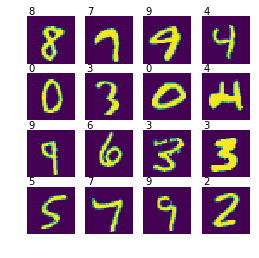

INFO:tensorflow:Restoring parameters from params/mnist-hidden-3.ckpt
Model mnist-hidden-3 Demonstration


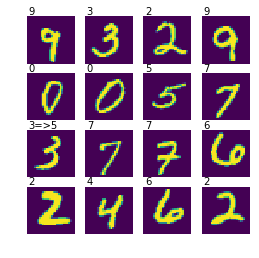

In [25]:
m4.demonstrate(16, True)
m5.demonstrate(16, True)